# Research Analysis Demo

This notebook demonstrates how to analyze research grant data using the complete evaluation pipeline:

1. **Load extracted keywords** from JSON results (automatically saved by hooks)
2. **Load taxonomy structure** from identify task results  
3. **Load grant classifications** from classify task results
4. **Analyze and visualize** the complete research landscape

The tasks now use hooks to automatically extract and save JSON results in an organized structure under `logs/results/`, making data analysis much simpler.

In [1]:
# Import required libraries
%load_ext autoreload
%autoreload 2

import json
import pandas as pd
from pathlib import Path
from modeling.tasks import (
    load_grants_data, load_taxonomy, load_grant_classifications,
    LOGS_DIR, DATA_DIR, GRANTS_FILE
)

## Helper Functions

Define functions for loading and processing the new JSON-based results structure.

In [2]:
def load_extracted_keywords_from_json(logs_dir):
    """Load extracted keywords from the new JSON results structure."""
    results_dir = Path(logs_dir) / "results" / "extract"
    
    if not results_dir.exists():
        return pd.DataFrame()
    
    all_keywords = []
    for json_file in results_dir.glob("*_keywords.json"):
        with open(json_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
            result = data['result'].copy()
            result['sample_id'] = data['sample_id']
            result['timestamp'] = data['timestamp']
            all_keywords.append(result)
    
    if not all_keywords:
        return pd.DataFrame()
    
    keywords_df = pd.DataFrame(all_keywords).set_index('sample_id')
    return keywords_df

In [3]:
def load_aggregated_results(logs_dir):
    """Load aggregated results from JSON files."""
    results_dir = Path(logs_dir) / "results"
    
    aggregated_data = {}
    
    # Load aggregated keywords
    keywords_file = results_dir / "all_keywords_extracted.json"
    if keywords_file.exists():
        with open(keywords_file, 'r', encoding='utf-8') as f:
            aggregated_data['keywords'] = json.load(f)
    
    # Load aggregated classifications
    classifications_file = results_dir / "all_grants_classified.json"
    if classifications_file.exists():
        with open(classifications_file, 'r', encoding='utf-8') as f:
            aggregated_data['classifications'] = json.load(f)
    
    return aggregated_data

In [4]:
def create_comprehensive_results_df(logs_dir, grants_file):
    """Create a comprehensive results dataframe combining all task outputs."""
    # Load keywords
    keywords_df = load_extracted_keywords_from_json(logs_dir)
    
    # Load grants data
    grants_df = load_grants_data(grants_file, as_dataframe=True)
    
    # Load taxonomy
    taxonomy = load_taxonomy(logs_dir)
    
    # Load classifications (from individual JSON files)
    results_dir = Path(logs_dir) / "results" / "classify"
    classifications = {}
    
    if results_dir.exists():
        for json_file in results_dir.glob("*_classification.json"):
            with open(json_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
                # Extract grant_id from sample_id (assuming pattern)
                sample_id = data['sample_id']
                classifications[sample_id] = data['result']['classification']
    
    # Create comprehensive dataframe
    results = keywords_df.copy()
    
    # Add taxonomy information
    if taxonomy:
        results['taxonomy_available'] = True
        results['total_categories'] = len(taxonomy.get('taxonomy', []))
    else:
        results['taxonomy_available'] = False
        results['total_categories'] = 0
    
    # Add classifications
    for sample_id, classification in classifications.items():
        if sample_id in results.index:
            results.loc[sample_id, 'top_level_category'] = classification.get('top_level_category')
            results.loc[sample_id, 'subcategory'] = classification.get('subcategory') 
            results.loc[sample_id, 'classification_reasoning'] = classification.get('reasoning')
    
    return results, grants_df, taxonomy, classifications

## Analysis Functions

Functions to analyze and visualize the complete research landscape data.

In [5]:
def analyze_keyword_categories(results_df):
    """Analyze keyword distribution across categories."""
    category_stats = {}
    
    for category in ['keywords', 'methodology_keywords', 'application_keywords', 'technology_keywords']:
        if category in results_df.columns:
            # Count total keywords in this category
            total_keywords = results_df[category].apply(lambda x: len(x) if x else 0).sum()
            # Count unique keywords
            all_keywords = [kw for kw_list in results_df[category].dropna() for kw in kw_list]
            unique_keywords = len(set(all_keywords))
            # Average keywords per grant
            avg_per_grant = results_df[category].apply(lambda x: len(x) if x else 0).mean()
            
            category_stats[category] = {
                'total_keywords': total_keywords,
                'unique_keywords': unique_keywords,
                'avg_per_grant': avg_per_grant,
                'most_common': pd.Series(all_keywords).value_counts().head(10)
            }
    
    return category_stats

In [6]:
def analyze_taxonomy_structure(taxonomy):
    """Analyze the taxonomy structure created by the identify task."""
    if not taxonomy or 'taxonomy' not in taxonomy:
        return None
    
    taxonomy_data = taxonomy['taxonomy']
    
    analysis = {
        'total_top_categories': len(taxonomy_data),
        'categories': []
    }
    
    for category in taxonomy_data:
        subcategories = category.get('subcategories', [])
        category_info = {
            'name': category['name'],
            'description': category['description'],
            'num_subcategories': len(subcategories),
            'subcategories': [sub['name'] for sub in subcategories]
        }
        analysis['categories'].append(category_info)
    
    analysis['total_subcategories'] = sum(cat['num_subcategories'] for cat in analysis['categories'])
    analysis['avg_subcategories_per_category'] = analysis['total_subcategories'] / analysis['total_top_categories']
    
    return analysis

In [7]:
def analyze_grant_classifications(results_df, classifications):
    """Analyze the distribution of grant classifications."""
    if 'top_level_category' not in results_df.columns:
        return None
    
    analysis = {
        'total_classified_grants': len(classifications),
        'classification_coverage': len(classifications) / len(results_df) * 100,
        'top_level_distribution': results_df['top_level_category'].value_counts(),
        'subcategory_distribution': results_df['subcategory'].value_counts()
    }
    
    # Cross-tabulation of top-level and subcategories
    if 'subcategory' in results_df.columns:
        crosstab = pd.crosstab(results_df['top_level_category'], 
                             results_df['subcategory'], 
                             dropna=False)
        analysis['category_subcategory_crosstab'] = crosstab
    
    return analysis

## Load and Process Data

Execute the main analysis pipeline using the new hooks-based JSON results.

In [11]:
# Check what results are available
results_dir = LOGS_DIR / "results"

available_results = {
    'extract': (results_dir / "extract").exists(),
    'identify': (results_dir / "identify").exists(), 
    'classify': (results_dir / "classify").exists(),
    'aggregated_keywords': (results_dir / "all_keywords_extracted.json").exists(),
    'aggregated_classifications': (results_dir / "all_grants_classified.json").exists()
}



/var/folders/k1/cn3zybm53kd95_crzqj9shg40000gn/T/ipykernel_96738/873164743.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


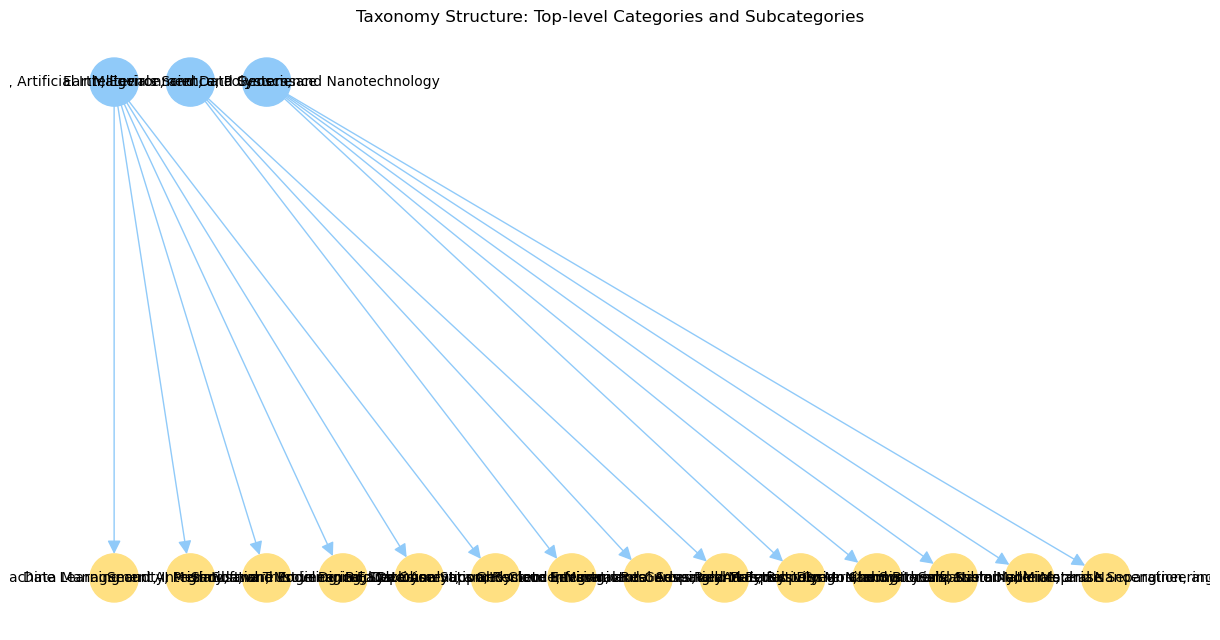

In [13]:
def plot_taxonomy_graph(taxonomy, max_categories=None):
    import networkx as nx
    import matplotlib.pyplot as plt

    if taxonomy and 'taxonomy' in taxonomy:
        taxonomy_data = taxonomy['taxonomy']
        if max_categories is not None:
            taxonomy_data = taxonomy_data[:max_categories]
        G = nx.DiGraph()

        # Add nodes and edges only for selected top-level categories
        top_cats = [cat['name'] for cat in taxonomy_data]
        sub_cats = []
        for cat in taxonomy_data:
            top_cat = cat['name']
            G.add_node(top_cat, level='top')
            for sub in cat.get('subcategories', []):
                sub_cat = sub['name']
                sub_cats.append(sub_cat)
                G.add_node(sub_cat, level='sub')
                G.add_edge(top_cat, sub_cat)

        # Position nodes: top categories at top, subcategories at bottom
        pos = {}
        for i, name in enumerate(top_cats):
            pos[name] = (i, 1)
        for i, name in enumerate(sub_cats):
            pos[name] = (i, 0)

        plt.figure(figsize=(12, 6))
        nx.draw(
            G, pos, with_labels=True,
            node_color=['#90caf9' if G.nodes[n]['level'] == 'top' else '#ffe082' for n in G.nodes],
            node_size=1200, arrowsize=20, font_size=10, edge_color='#90caf9'
        )
        plt.title('Taxonomy Structure: Top-level Categories and Subcategories')
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ No taxonomy available for network visualization")
taxonomy = load_taxonomy(LOGS_DIR)
plot_taxonomy_graph(taxonomy, max_categories=3)

## Detailed Analysis

Examine classifications, sample data, and create comprehensive analysis outputs.

In [12]:
# Analyze grant classifications
if classifications and available_results['classify']:
    classification_analysis = analyze_grant_classifications(results_df, classifications)
    
    if classification_analysis:
        print("🎯 Classification Analysis:")
        print(f"  Total classified grants: {classification_analysis['total_classified_grants']}")
        print(f"  Coverage: {classification_analysis['classification_coverage']:.1f}% of grants")
        
        print(f"\nTop-level category distribution:")
        for category, count in classification_analysis['top_level_distribution'].head().items():
            print(f"  📊 {category}: {count} grants")
        
        print(f"\nMost common subcategories:")
        for subcategory, count in classification_analysis['subcategory_distribution'].head(3).items():
            print(f"  🔖 {subcategory}: {count} grants")
    else:
        print("⚠️ Classification analysis not available")
else:
    print("⚠️ No classifications available for analysis")

⚠️ Classification analysis not available


In [ ]:
# Show sample taxonomy structure  
if taxonomy and 'taxonomy' in taxonomy:
    print("📋 Sample Taxonomy Structure:")
    
    # Show first category in detail
    first_category = taxonomy['taxonomy'][0]
    print(f"\nCategory: {first_category['name']}")
    print(f"Description: {first_category['description']}")
    print("Subcategories:")
    for sub in first_category.get('subcategories', [])[:5]:  # Show first 5
        print(f"  • {sub['name']}: {sub['description']}")
    
    if len(first_category.get('subcategories', [])) > 5:
        print(f"  ... and {len(first_category.get('subcategories', [])) - 5} more")
else:
    print("⚠️ No taxonomy structure available to display")

Sample harmonisation groups:

1. ['3-D imaging software', '3D volumetric image reconstruction', '3D volumetric imaging system'] → '3D Volumetric Imaging'

2. ['3-D seismic modeling', '3-D seismic structure'] → '3D seismic structure'

3. ['3D geological modelling'] → '3D geological modelling'

4. ['3D laser scanning', 'LiDAR scanning', 'LiDAR terrain mapping'] → 'LiDAR scanning'

5. ['3D peptide structure determination'] → '3D peptide structure determination'


In [ ]:
# Show comprehensive sample data
if available_results['extract'] and not results_df.empty:
    sample_idx = results_df.index[0]
    sample = results_df.iloc[0]
    
    # Get corresponding grant data
    grant_data = None
    if sample_idx in grants_df.index:
        grant_data = grants_df.loc[sample_idx]
    
    print("📋 Sample Grant Analysis:")
    if grant_data is not None:
        print(f"Title: {grant_data['title'][:100]}...")
        print(f"Funder: {grant_data.get('funder', 'N/A')}")
        print(f"Funding: ${grant_data.get('funding_amount', 'N/A'):,}" if grant_data.get('funding_amount') else "Funding: N/A")
    
    print(f"\n🔤 Extracted Keywords:")
    for category in ['keywords', 'methodology_keywords', 'application_keywords', 'technology_keywords']:
        if category in sample.index and sample[category]:
            print(f"  {category.replace('_', ' ').title()}: {sample[category][:3]}{'...' if len(sample[category]) > 3 else ''}")
    
    # Show classification if available
    if 'top_level_category' in sample.index and pd.notna(sample['top_level_category']):
        print(f"\n🎯 Classification:")
        print(f"  Category: {sample['top_level_category']}")
        print(f"  Subcategory: {sample.get('subcategory', 'N/A')}")
        if 'classification_reasoning' in sample.index:
            reasoning = sample['classification_reasoning']
            print(f"  Reasoning: {reasoning[:100]}{'...' if len(str(reasoning)) > 100 else ''}")
else:
    print("⚠️ No sample data available to display")

Sample grant:
Title: Industrial Transformation Training Centres - Grant ID: IC230100035...
Funder: Australian Research Council
Funding: $5,000,000.0

Original keywords: ['Critical resources', 'Critical minerals', 'Mineral systems science']...
Harmonised keywords: ['Critical resources', 'Critical minerals', 'Mineral systems science']...


In [ ]:
# Create comprehensive SQLite database
import sqlite3
import uuid
from pathlib import Path

# Database setup
db_path = Path("../data/research_analysis.db")
db_path.parent.mkdir(exist_ok=True)

if available_results['extract']:
    conn = sqlite3.connect(db_path)
    
    try:
        # 1. Grants table (base grant information)
        grants_table = grants_df.copy()
        grants_table.to_sql('grants', conn, if_exists='replace', index=True)
        
        # 2. Keywords table (all extracted keywords with metadata)
        keywords_table = results_df[['keywords', 'methodology_keywords', 
                                   'application_keywords', 'technology_keywords', 'timestamp']].copy()
        keywords_table.to_sql('extracted_keywords', conn, if_exists='replace', index=True)
        
        # 3. Classifications table (if available)
        if classifications and 'top_level_category' in results_df.columns:
            classifications_table = results_df[['top_level_category', 'subcategory', 
                                              'classification_reasoning']].copy()
            classifications_table = classifications_table.dropna(subset=['top_level_category'])
            classifications_table.to_sql('grant_classifications', conn, if_exists='replace', index=True)
        
        # 4. Taxonomy table (if available)
        if taxonomy:
            taxonomy_data = []
            for cat in taxonomy['taxonomy']:
                for sub in cat.get('subcategories', []):
                    taxonomy_data.append({
                        'top_level_category': cat['name'],
                        'top_level_description': cat['description'],
                        'subcategory': sub['name'],
                        'subcategory_description': sub['description']
                    })
            
            if taxonomy_data:
                taxonomy_df = pd.DataFrame(taxonomy_data)
                taxonomy_df.to_sql('taxonomy_structure', conn, if_exists='replace', index=False)
        
        # Show results
        print(f"✅ Comprehensive database created: {db_path.absolute()}")
        
        # Get table info
        cursor = conn.cursor()
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = cursor.fetchall()
        
        for table_name, in tables:
            cursor.execute(f"SELECT COUNT(*) FROM {table_name}")
            count = cursor.fetchone()[0]
            print(f"📊 {table_name}: {count:,} records")
    
    finally:
        conn.close()
        
    print(f"\n🎉 Analysis complete! Database contains:")
    print(f"  ? Grant information and metadata") 
    print(f"  🔤 Extracted keywords by category")
    if classifications:
        print(f"  🎯 Grant classifications")
    if taxonomy:
        print(f"  🏗️ Taxonomy structure")
else:
    print("❌ Cannot create database without extracted keywords. Run tasks first.")

✅ Database created: /Users/luhancheng/Desktop/research-link-technology-landscaping/modeling/../data/research_keywords.db
📊 100 grants
🏷️ 37 harmonised keywords
🔗 61 grant-keyword links


## Summary

This notebook demonstrates the complete research analysis pipeline using the new hooks-based architecture:

### 🔄 **Pipeline Overview:**
1. **Extract Task** (`inspect eval modeling/tasks.py@extract`)
   - Extracts keywords from grant titles and summaries
   - Automatically saves results to `logs/results/extract/`

2. **Identify Task** (`inspect eval modeling/tasks.py@identify`) 
   - Creates 2-level taxonomy from extracted keywords
   - Saves taxonomy structure to `logs/results/identify/`

3. **Classify Task** (`inspect eval modeling/tasks.py@classify`)
   - Classifies grants using the created taxonomy
   - Saves classifications to `logs/results/classify/`

### 📊 **Key Benefits:**
- **Automated JSON extraction** via hooks - no manual log parsing needed
- **Structured data organization** in `logs/results/` directory  
- **Comprehensive analysis** combining all task outputs
- **Database creation** for further research and querying
- **Error handling** and metadata preservation

### 🎯 **Next Steps:**
- Run SQL queries on the created database for deeper analysis
- Visualize keyword distributions and classification patterns
- Export results for reporting or further processing
- Scale the pipeline to larger grant datasets